# Let's explore EXFOR offerings for Ca40

In [1]:
import pickle
from pathlib import Path
from periodictable import elements
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import exfor_tools

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


In [3]:
from query_elastic import print_failed_parses, query_elastic_data, reattempt_parse

In [4]:
import jitr

In [5]:
proton = (1, 1)
neutron = (1, 0)

In [6]:
target =(206,82)

In [7]:
(
    (entries_pp, failed_parses_pp),
    (entries_ppr, failed_parses_ppr),
    (entries_nn, failed_parses_nn),
) = query_elastic_data(target)


Parsing (p,p) ...

Succesfully parsed 0 entries for (p,p)
Failed to parse 0 entries



Parsing (p,p) ratio ...
Found subentry O0788008 with the following columns:
['EN', 'EN-ERR', 'ANG-ERR-D', 'ANG-CM', 'DATA', 'ERR-T']

Succesfully parsed 1 entries for (p,p) ratio
Failed to parse 0 entries



Parsing (n,n)...
Failed to parse subentry 10633020:
	Subentry 10633020 has an ambiguous set of error labels:
		DATA-ERR2, MONIT-ERR, DATA-ERR1, 
Found subentry 22048024 with the following columns:
['EN', 'EN-RSL', 'ANG-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']

Succesfully parsed 1 entries for (n,n)
Failed to parse 1 entries




# $(p,p)$

## Handle failed parses for $(p,p)$

In [8]:
print_failed_parses(failed_parses=failed_parses_pp)

## Reject none-useful, discrepant our outlying experiments

# $(p,p)$ ratio

## handle failed parses for $(p,p)$ ratio

In [9]:
print_failed_parses(failed_parses=failed_parses_ppr)

## Reject non-useful, discrepant our outlying experiments

## handle failed parses for $(n,n)$ ratio

In [10]:
print_failed_parses(failed_parses=failed_parses_nn)

Entry: 10633
Subentry 10633020 has an ambiguous set of error labels:
		DATA-ERR2, MONIT-ERR, DATA-ERR1, 


In [11]:
entries_nn["10633"] = reattempt_parse(
    failed_parses_nn["10633"],
    parsing_kwargs={
        "err_labels": [ "DATA-ERR1", "DATA-ERR2",],
        "err_treatment": "independent",
    },
)

Found subentry 10633020 with the following columns:
['EN', 'DATA-ERR2', 'ANG-NRM', 'MONIT', 'MONIT-ERR', 'ANG-RSL', 'ANG-CM', 'DATA-CM', 'DATA-ERR1']


# Plotting

## Plot $(p,p)$

## plot $(p,p)$ ratio

In [14]:
measurements_categorized = exfor_tools.categorize_measurements_by_energy(
    entries_ppr, min_num_pts=4
)

In [15]:
[[(m.subentry, m.Einc) for m in l] for l in measurements_categorized]

[[('O0788008', 49.35)]]

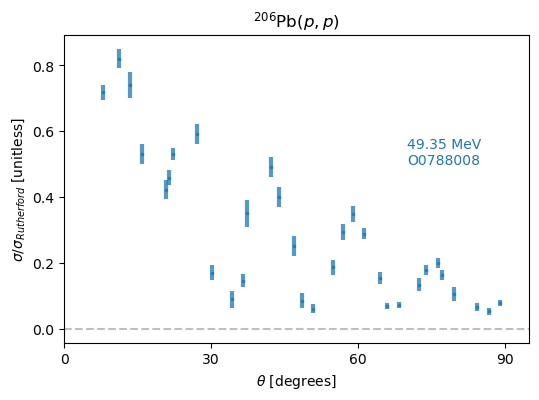

In [21]:
n_per_plot = 9
N = len(measurements_categorized)
num_plots = N // n_per_plot
left_over = N % n_per_plot
if left_over > 0:
    num_plots += 1


fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))
if not isinstance(axes,list):
    axes = [axes]

for i in range(num_plots):
    idx0 = i * n_per_plot
    if i == num_plots - 1:
        idxf = N 
    else:
        idxf = (i + 1) * n_per_plot
    exfor_tools.plot_angular_distributions(
        measurements_categorized[idx0:idxf],
        axes[i],
        offsets=5,
        data_symbol=list(entries_ppr.values())[0].data_symbol,
        rxn_label=list(entries_ppr.values())[0].rxn,
        label_kwargs={
            "label_xloc_deg": 70,
            "label_offset_factor": 0.5,
            "label_energy_err": False,
            "label_offset": False,
            "label_incident_energy": True,
            "label_excitation_energy": False,
            "label_exfor": True,
        },
        log=False,
        draw_baseline=True
    )
    axes[i].set_xlim([0,95])

## Plot $(n,n)$

In [22]:
measurements_categorized = exfor_tools.categorize_measurements_by_energy(
    entries_nn, min_num_pts=5
)

In [23]:
[[m.Einc for m in l] for l in measurements_categorized]

[[11.01], [21.6]]

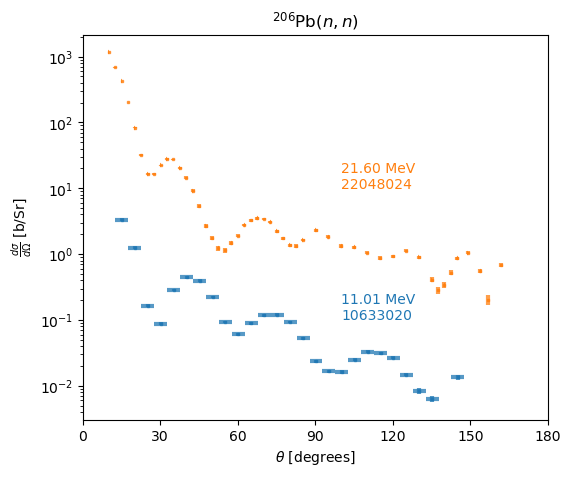

In [35]:
n_per_plot = 6
N = len(measurements_categorized)
num_plots = N // n_per_plot
left_over = N % n_per_plot
if left_over > 0:
    num_plots += 1


fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))
if not isinstance(axes,list):
    axes = [axes]

for i in range(num_plots):
    idx0 = i * n_per_plot
    if i == num_plots - 1:
        idxf = N 
    else:
        idxf = (i + 1) * n_per_plot

    exfor_tools.plot_angular_distributions(
        measurements_categorized[idx0:idxf],
        axes[i],
        offsets=100,
        data_symbol=list(entries_nn.values())[0].data_symbol,
        rxn_label=list(entries_nn.values())[0].rxn,
        label_kwargs={
            "label_xloc_deg": 100,
            "label_offset_factor": 0.1,
            "label_energy_err": False,
            "label_offset": False,
            "label_incident_energy": True,
            "label_excitation_energy": False,
            "label_exfor": True,
        },
    )


# Write data to disk

In [36]:
A, Z = target
with open(f"{elements[Z]}{A}_diff_xs.pkl", "wb") as f:
    pickle.dump({"n,n": entries_nn, "p,p": { "absolute" :  entries_pp , "ratio" : entries_ppr }}, f)